In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras

In [16]:
# Load the dataset
df = pd.read_csv('goals_predict.csv')

# One-hot encode 'position' and 'foot'
df_processed = pd.get_dummies(df, columns=['position', 'foot'], dtype=int)

# Convert 'age_at_season_start' to integer
df_processed['age_at_season_start'] = df_processed['age_at_season_start'].astype(int)

# Define features (X) and targets (y)
# Drop columns not needed for training, including the original target columns for X
X = df_processed.drop([
    'player_id', 'name', 'avg_market_value_season',
    'foot_both', 'position_Missing', # 'foot_both' and 'position_Missing' are often dropped after one-hot encoding to avoid multicollinearity
    'total_goals_season', 'total_assists_season'
], axis=1)
y = df_processed[['total_goals_season', 'total_assists_season']]

print("Data loading and initial preprocessing complete using Pandas.")
print("X head:")
print(X.head())
print("\nY head:")
print(y.head())


Data loading and initial preprocessing complete using Pandas.
X head:
   season  age_at_season_start  height_in_cm  appearances_season  \
0    2012                   34         184.0                  36   
1    2013                   35         184.0                  29   
2    2014                   36         184.0                  40   
3    2015                   37         184.0                  31   
4    2012                   31         179.0                  15   

   total_minutes_played_season  position_Attack  position_Defender  \
0                         2585                1                  0   
1                         2220                1                  0   
2                         2289                1                  0   
3                         1714                1                  0   
4                          904                0                  0   

   position_Midfield  foot_left  foot_right  
0                  0          0           1  
1       

In [17]:
# --- 2. Train-Test Split ---
# Using sklearn's train_test_split for convenience and best practices
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("\nTrain-test split complete using Scikit-learn.")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")



Train-test split complete using Scikit-learn.
X_train shape: (61832, 10)
X_test shape: (15459, 10)
y_train shape: (61832, 2)
y_test shape: (15459, 2)


In [18]:
# --- 3. Scaling (Standardization) for X, and Log Transformation for Y (without Y scaling) ---
# Identify numerical columns in X for standardization
numerical_cols_X = [col for col in X_train.columns if not (col.startswith('position_') or col.startswith('foot_'))]
# Initialize and fit StandardScaler for X on training data
scaler_X = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numerical_cols_X] = scaler_X.fit_transform(X_train[numerical_cols_X])
X_test_scaled[numerical_cols_X] = scaler_X.transform(X_test[numerical_cols_X])
# Log transform y (goals and assists) - DO NOT STANDARDIZE Y AFTER LOG TRANSFORM
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)
# We still need a scaler_y to inverse transform the predictions later,
# even if we don't use it for scaling the training targets for the model.
# This scaler will be fitted on the log-transformed training data.
scaler_y = StandardScaler()
# Fit scaler_y on y_train_log, but we won't use its transform for model input
# We just need its mean and std for inverse_transform later.
scaler_y.fit(y_train_log)
# Convert to NumPy arrays for TensorFlow
X_train_scaled_np = X_train_scaled.values.astype(float)
y_train_log_np = y_train_log.values.astype(float)
X_test_scaled_np = X_test_scaled.values.astype(float)
y_test_log_np = y_test_log.values.astype(float)
print("\nScaling for X and Log transformation for Y complete (Y is NOT scaled).")
print("X_train_scaled_np shape:", X_train_scaled_np.shape)
print("y_train_log_np shape:", y_train_log_np.shape)
print("y_train_log (first 5 rows, as numpy array):")
print(y_train_log_np[:5])


Scaling for X and Log transformation for Y complete (Y is NOT scaled).
X_train_scaled_np shape: (61832, 10)
y_train_log_np shape: (61832, 2)
y_train_log (first 5 rows, as numpy array):
[[1.38629436 0.        ]
 [0.69314718 0.        ]
 [0.         0.69314718]
 [0.69314718 0.        ]
 [1.09861229 0.        ]]


In [19]:
# --- 4. Define the MLP Model Architecture as a build_model function for Keras Tuner (with softplus output) ---
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Poisson
def build_model(hp):
    model = Sequential()
    # Tune the number of units in the first Dense layer
    model.add(Dense(units=hp.Int('units_1', min_value=32, max_value=128, step=32),
                    activation='relu',
                    input_shape=(X_train_scaled_np.shape[1],))) # Use X_train_scaled_np.shape[1]
    # Tune the dropout rate for the first dropout layer
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))
    # Tune the number of units in the second Dense layer
    model.add(Dense(units=hp.Int('units_2', min_value=16, max_value=64, step=16),
                    activation='relu'))
    # Tune the dropout rate for the second dropout layer
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)))
    # Output Layer
    # Use 'softplus' activation to ensure non-negative predictions for Poisson loss
    model.add(Dense(y_train_log_np.shape[1], activation='softplus')) # Use y_train_log_np.shape[1]
    # Tune the learning rate for the Adam optimizer
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    optimizer = Adam(learning_rate=learning_rate)
    # Compile the model with Poisson loss
    model.compile(optimizer=optimizer,
                loss=Poisson(),
                metrics=['mae'])
    return model
print("\n'build_model' function defined for Keras Tuner with 'softplus' output activation.")
print("It will tune: units in hidden layers, dropout rates, and learning rate.")



'build_model' function defined for Keras Tuner with 'softplus' output activation.
It will tune: units in hidden layers, dropout rates, and learning rate.


In [ ]:
# --- 4. Define the MLP Model Architecture for a Deeper and Wider Search ---
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Poisson
def build_model(hp):
    model = Sequential()
    # --- First Hidden Layer ---
    # Tune the number of units, allowing for larger layers
    model.add(Dense(
        units=hp.Int('units_1', min_value=32, max_value=256, step=32),
        activation='relu',
        input_shape=(X_train_scaled_np.shape[1],)
    ))
    # Tune the dropout rate
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))
    # --- Second Hidden Layer ---
    # Tune the number of units
    model.add(Dense(
        units=hp.Int('units_2', min_value=16, max_value=128, step=16),
        activation='relu'
    ))
    # Tune the dropout rate
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)))
    # --- Optional Third Hidden Layer ---
    # Use a boolean hyperparameter to decide whether to include this layer at all
    if hp.Boolean('use_third_layer'):
        model.add(Dense(
            # Tune the number of units for the third layer
            units=hp.Int('units_3', min_value=8, max_value=64, step=16),
            activation='relu'
        ))
        # Tune the dropout rate for the third layer
        model.add(Dropout(rate=hp.Float('dropout_3', min_value=0.0, max_value=0.5, step=0.1)))
    # --- Output Layer ---
    # Use 'softplus' activation to ensure non-negative predictions for Poisson loss
    model.add(Dense(y_train_log_np.shape[1], activation='softplus'))
    # --- Optimizer ---
    # Tune the learning rate for the Adam optimizer
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    optimizer = Adam(learning_rate=learning_rate)
    # --- Compilation ---
    # Compile the model with Poisson loss
    model.compile(
        optimizer=optimizer,
        loss=Poisson(),
        metrics=['mae']
    )
    return model
print("\n'build_model' function updated for a deeper and wider architecture search.")
print("It will now tune:")
print("  - Up to 3 hidden layers.")
print("  - More units per layer.")
print("  - Dropout rates for all layers.")
print("  - Learning rate.")


In [20]:
# --- 5. Set up and Run Keras Tuner Search (using new numpy arrays) ---
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)
print("\nSetting up Keras Tuner RandomSearch...")
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective='val_mae',
    max_trials=20,
    executions_per_trial=1,
    directory='keras_tuner_dir',
    project_name='goals_assists_mlp_tuning_v2' # Changed project name to avoid conflicts
)
tuner.search_space_summary()
print("\nStarting Keras Tuner search...")
tuner.search(
    X_train_scaled_np, # Use the new numpy array
    y_train_log_np,    # Use the new numpy array
    epochs=200,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)
print("\nKeras Tuner search complete.")


Trial 20 Complete [00h 01m 53s]
val_mae: 0.3817687928676605

Best val_mae So Far: 0.37885794043540955
Total elapsed time: 02h 11m 06s

Keras Tuner search complete.


In [24]:
# --- 6. Get the Best Model and Evaluate (using new numpy arrays and inverse transform) ---
print("\nRetrieving the best model from Keras Tuner...")
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters found:")
print(f"  Units in first hidden layer: {best_hps.get('units_1')}")
print(f"  Dropout rate for first hidden layer: {best_hps.get('dropout_1')}")
print(f"  Units in second hidden layer: {best_hps.get('units_2')}")
print(f"  Dropout rate for second hidden layer: {best_hps.get('dropout_2')}")
print(f"  Learning rate: {best_hps.get('learning_rate')}")
best_model = tuner.hypermodel.build(best_hps)
print("\nRetraining the best model on the full training dataset...")
history_best_model = best_model.fit(
    X_train_scaled_np, # Use the new numpy array
    y_train_log_np,    # Use the new numpy array
    epochs=200,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)
print("\nEvaluating the best model on test data and inverse transforming predictions...")
# Make predictions on the scaled test data using the best model
y_test_pred_log_transformed = best_model.predict(X_test_scaled_np) # Predictions are now log-transformed
# Inverse transform the predictions to the original scale
# First, inverse standardize using scaler_y (which was fitted on log-transformed y)
# Note: Since we didn't scale y_train_log, scaler_y.inverse_transform will effectively just
# use its mean/std to "un-standardize" if it was used for standardization.
# However, if scaler_y was only fitted, its inverse_transform will still work correctly
# to reverse any potential scaling it *would* have done.
# The key is that y_test_pred_log_transformed is already in the log-transformed space.
# So, we just need to apply expm1.
# The softplus output activation ensures non-negativity.
# The predictions y_test_pred_log_transformed are already in the log-transformed space
# (because softplus(x) behaves like log(1+exp(x)) for large x, and we are training
# it to predict log(1+y)).
# So, we directly apply np.expm1 to get the final predictions.
y_test_pred_final = np.expm1(y_test_pred_log_transformed)
# Ensure predictions are non-negative (softplus already helps, but a final clip is safe)
y_test_pred_final[y_test_pred_final < 0] = 0
# Convert actual y_test to a NumPy array for direct comparison
y_actual = y_test.values
# Calculate evaluation metrics on the original scale
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(y_actual, y_test_pred_final)
mae = mean_absolute_error(y_actual, y_test_pred_final)
print(f"\nFinal Evaluation of Best Model on Test Data (Original Scale):")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
# Display a comparison of actual vs. predicted for a few samples
df_compare = pd.DataFrame({
    'Actual_goals': y_actual[:10, 0],
    'Predicted_goals': y_test_pred_final[:10, 0],
    'Actual_assists': y_actual[:10, 1],
    'Predicted_assists': y_test_pred_final[:10, 1]
})
print("\nSample Predictions vs Actuals (first 10 test samples from Best Model):")
print(df_compare)


Retrieving the best model from Keras Tuner...
Best Hyperparameters found:
  Units in first hidden layer: 96
  Dropout rate for first hidden layer: 0.0
  Units in second hidden layer: 32
  Dropout rate for second hidden layer: 0.2
  Learning rate: 0.001


/home/areeb/football/venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Retraining the best model on the full training dataset...
Epoch 1/200
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.7171 - mae: 0.4055 - val_loss: 0.7043 - val_mae: 0.3845
Epoch 2/200
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.7067 - mae: 0.3926 - val_loss: 0.7029 - val_mae: 0.3831
Epoch 3/200
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.7054 - mae: 0.3914 - val_loss: 0.7027 - val_mae: 0.3848
Epoch 4/200
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.7043 - mae: 0.3900 - val_loss: 0.7039 - val_mae: 0.3905
Epoch 5/200
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.7038 - mae: 0.3901 - val_loss: 0.7026 - val_mae: 0.3788
Epoch 6/200
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.7030 - mae: 0.3888 - val_loss: 0.7020 - val_mae: 0.3856
Epoch 7/200
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.7030 - mae: 0.3884 - val_loss: 0.7014 - val_mae: 0.3848
Epoch 8/200
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.7026 - mae: 0.3883 - val_los


Plotting learning curves for the best model...


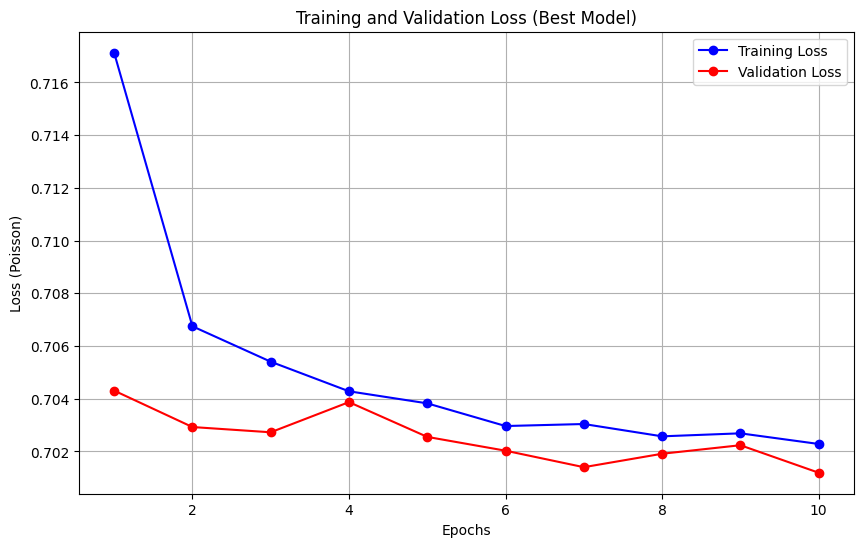

Learning curves for the best model plotted. Analyze the plot to determine model fit.


In [25]:
# --- Plot Learning Curves for the Best Model ---
import matplotlib.pyplot as plt
print("\nPlotting learning curves for the best model...")
# Get the loss and validation loss from the history object of the best model
loss = history_best_model.history['loss']
val_loss = history_best_model.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss (Best Model)')
plt.xlabel('Epochs')
plt.ylabel('Loss (Poisson)') # Note: The loss is now Poisson loss
plt.legend()
plt.grid(True)
plt.show()
print("Learning curves for the best model plotted. Analyze the plot to determine model fit.")

In [26]:
# --- Output Training and Validation Loss at Start and End (for Best Model) ---
print("\n--- Training and Validation Loss Summary (Best Model) ---")
# Loss at the start of training (first epoch)
initial_train_loss = history_best_model.history['loss'][0]
initial_val_loss = history_best_model.history['val_loss'][0]
print(f"Initial Training Loss (Epoch 1): {initial_train_loss:.4f}")
print(f"Initial Validation Loss (Epoch 1): {initial_val_loss:.4f}")
# Loss at the end of training (last epoch)
final_train_loss = history_best_model.history['loss'][-1]
final_val_loss = history_best_model.history['val_loss'][-1]
print(f"Final Training Loss (Epoch {len(history_best_model.history['loss'])}): {final_train_loss:.4f}")
print(f"Final Validation Loss (Epoch {len(history_best_model.history['loss'])}): {final_val_loss:.4f}")
print("------------------------------------------")


--- Training and Validation Loss Summary (Best Model) ---
Initial Training Loss (Epoch 1): 0.7171
Initial Validation Loss (Epoch 1): 0.7043
Final Training Loss (Epoch 10): 0.7023
Final Validation Loss (Epoch 10): 0.7012
------------------------------------------


In [ ]:
# --- 7. Save the Best Model and Scalers for Deployment ---
import os
import pickle
from tensorflow.keras.models import load_model
# Define the directory to save the assets
save_dir = 'saved_model/fnn_tuned'
os.makedirs(save_dir, exist_ok=True)
# --- Save the Final Trained Model ---
# The 'best_model' is the one you retrained on the full dataset after getting the best hyperparameters.
model_path = os.path.join(save_dir, 'fnn_model.keras')
best_model.save(model_path)
print(f"✅ Best model saved to:  {model_path}")
# --- Save the Feature Scaler (scaler_X) ---
# This scaler was fitted on the training features and is needed to process new input data.
scaler_X_path = os.path.join(save_dir, 'scaler_X.pkl')
with open(scaler_X_path, 'wb') as f:
    pickle.dump(scaler_X, f)
print(f"✅ Feature scaler (scaler_X) saved to:  {scaler_X_path}")
# --- Save the Target Scaler (scaler_y) ---
# This scaler was fitted on the log-transformed training targets.
# It's crucial for inverse-transforming the model's predictions back to the original scale (goals/assists).
scaler_y_path = os.path.join(save_dir, 'scaler_y.pkl')
with open(scaler_y_path, 'wb') as f:
    pickle.dump(scaler_y, f)
print(f"✅ Target scaler (scaler_y) saved to:  {scaler_y_path}")
print("\nAll necessary assets for deployment have been saved successfully.")
